In [37]:
# librerias
import h5py as h5
from pyhdf.SD import SD, SDC
import tables
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from numpy import meshgrid
from scipy.interpolate import griddata as gd
import os
%matplotlib inline

In [38]:
# nombre del archivo
file_name = '../data/MYD09CMA.A2018015.006.2018017024441.hdf'

# nombre del dataset
DATASET = 'Coarse Resolution Atmospheric Optical Depth QA'

# constantes Caborca
LONG_MIN = -115.65
LONG_MAX = -107.94
LAT_MIN = 25.41
LAT_MAX = 33.06

In [39]:
# leer archivo
file = SD(file_name, SDC.READ)

In [40]:
# datasets
datasets_dic = file.datasets()

for idx,sds in enumerate(datasets_dic.keys()):
    print (idx,sds)

0 Coarse Resolution Surface Reflectance Band 8
1 Coarse Resolution Surface Reflectance Band 9
2 Coarse Resolution Surface Reflectance Band 10
3 Coarse Resolution Surface Reflectance Band 11
4 Coarse Resolution Surface Reflectance Band 12
5 Coarse Resolution TOA Reflectance Band 1
6 Coarse Resolution TOA Reflectance Band 3
7 Coarse Resolution TOA Reflectance Band 8
8 Coarse Resolution TOA Reflectance Band 9
9 Coarse Resolution TOA Reflectance Band 10
10 Coarse Resolution AOT Model Residual Values
11 Coarse Resolution AOT at 550 nm
12 Coarse Resolution Atmospheric Optical Depth Model
13 Coarse Resolution Water Vapor
14 Coarse Resolution Air Temperature (2m)
15 Coarse Resolution Atmospheric Optical Depth QA
16 Coarse Resolution Number Mapping AOT


In [41]:
sds_obj = file.select(DATASET) # select sds

data = sds_obj.get() # get sds data
print (data)

[[127 127 127 ..., 127 127 127]
 [127 127 127 ..., 127 127 127]
 [127 127 127 ..., 127 127 127]
 ..., 
 [127  10  10 ...,  10  10  10]
 [127  10  10 ...,  10  10  10]
 [127  10  10 ...,  10  10  10]]


In [42]:
# atributos
import pprint
pprint.pprint(sds_obj.attributes())

{'QA index': '\n'
             '\tNot bitmapped, but with the following values:\n'
             '\t0      inital value;\n'
             '\t1      None of the 500m pixels that correspond to this 1km '
             'pixel \n'
             '\t         has data that reaches either criteria for containing '
             'aerosols;\n'
             '\t2      Pixel is over water;\n'
             '\t3      One or more of the retrieved aerosol values has '
             'saturated\n'
             '\t         (and then all are set to a fill value);\n'
             '\t4      Pixel is cloudy or mixed or has a high band 26 value;\n'
             '\t5      Pixel had been flagged as water, but also had positive '
             'NDVI;\n'
             '\t6      Pixel is flagged as water and tests clear;\n'
             '\t7      Pixel is flagged as water and tests for turbidity;\n'
             '\t8      Snow (set in aot_filter());\n'
             '\t9      Bad geolocation, or high solar zenith;\n'
      

In [43]:
for key, value in sds_obj.attributes().items():
    print (key, value)
    if key == 'add_offset':
        add_offset = value  
    if key == 'scale_factor':
        scale_factor = value

_FillValue 127
valid_range [0, 19]
units (unitless)
long_name Coarse Resolution Atmospheric Optical Depth QA
QA index 
	Not bitmapped, but with the following values:
	0      inital value;
	1      None of the 500m pixels that correspond to this 1km pixel 
	         has data that reaches either criteria for containing aerosols;
	2      Pixel is over water;
	3      One or more of the retrieved aerosol values has saturated
	         (and then all are set to a fill value);
	4      Pixel is cloudy or mixed or has a high band 26 value;
	5      Pixel had been flagged as water, but also had positive NDVI;
	6      Pixel is flagged as water and tests clear;
	7      Pixel is flagged as water and tests for turbidity;
	8      Snow (set in aot_filter());
	9      Bad geolocation, or high solar zenith;
	10     Snow, or sunglint, or fire;
	11     Bad 500m data, no aerosol retrieval;
	12     Subpixel cloud (set in aot_filter());
	13     Aerosol retrieval anomalies;
	14     Possible salt-pan;
	15     Dese

In [44]:
# generar valores para x y y
x = np.linspace(-180,180, data.shape[1])
y = np.linspace(-90,90, data.shape[0])

In [45]:
# generar dataFrame
xi = []
yi = []
zi = []

for i in range(len(x)):
    for j in range(len(y)):
        xi.append(x[i])
        yi.append(y[j])
        zi.append(data[j,i])

In [46]:
len(xi)
len(yi)
len(zi)

25920000

In [47]:
arr = np.stack((xi,yi,zi), axis=1)

In [48]:
cols = ['lon', 'lat', 'value']

In [49]:
df = pd.DataFrame(arr, columns=cols)

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25920000 entries, 0 to 25919999
Data columns (total 3 columns):
lon      float64
lat      float64
value    float64
dtypes: float64(3)
memory usage: 593.3 MB


In [51]:
# limites longitud > -115.65 y < -107.94
df = df.loc[df['lon'] > LONG_MIN]
df = df.loc[df['lon'] < LONG_MAX]

# limites latitud > 25.41 y < 33.06
df = df.loc[df['lat'] > LAT_MIN]
df = df.loc[df['lat'] < LAT_MAX]

# obtener valores de x, y
lons = np.array(df['lon'])
lats = np.array(df['lat'])

In [52]:
len(lons)

23562

In [53]:
m = Basemap(projection='mill',llcrnrlat=LAT_MIN,urcrnrlat=LAT_MAX,llcrnrlon=LONG_MIN,urcrnrlon=LONG_MAX,resolution='h')

# generar lats, lons
x, y = m(lons, lats)

# numero de columnas y filas
numCols = len(x)
numRows = len(y)

# generar xi, yi
xi = np.linspace(x.min(), x.max(), 100)
yi = np.linspace(y.min(), y.max(), 100)

# generar el meshgrid
xi, yi = np.meshgrid(xi, yi)

# generar zi
z = np.array(df['value'])
zi = gd((x,y), z, (xi,yi), method='cubic')

****** Genereate: test.png


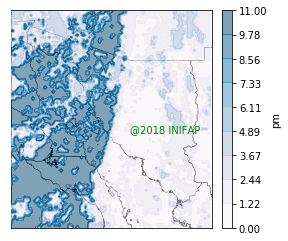

In [54]:
stepVariable = 1
step = (z.max() - z.min()) / 10

# verificar el valor del intervalo
if step <= 1:
    stepVariable = 1

clevs = np.linspace(z.min(), z.max() + stepVariable , 10)
#clevs = [1,2,3,4,5,6,7,8,9,10]

# contour plot
cs = m.contourf(xi,yi,zi, clevs, zorder=5, alpha=0.5, cmap='PuBu')

# agregar archivo shape de estados
m.readshapefile('../shapes/Estados', 'Estados')

# colorbar
cbar = m.colorbar(cs, location='right', pad="5%")
cbar.set_label('pm')
plt.annotate('@2018 INIFAP', xy=(-109,29), xycoords='figure fraction', xytext=(0.45,0.45), color='g', zorder=50)

# nombre
nombreTemporalParaElMapa = "test.png"
plt.savefig(nombreTemporalParaElMapa, dpi=300)
print('****** Genereate: {}'.format(nombreTemporalParaElMapa))